In [53]:
import tensorflow as tf

import pandas as pd
import numpy as np

import config

from sklearn.model_selection import StratifiedKFold
from DataLoader import FeatureDictionary, DataParser

from DCN import DCN


In [32]:
dfTrain = pd.read_csv(config.TRAIN_FILE)
dfTest = pd.read_csv(config.TEST_FILE)
dfTrain.head()


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [36]:
def preprocess(df):
    # 将除了 id target 以外的每一列进行处理
    # 统计该样本所有特征中值==-1的个数，新建一个missing_feat 特征进行保存
    # 新建一个ps_car_13_x_ps_reg_03特征，其值为  ps_car_13*ps_reg_03
    cols = [c for c in df.columns if c not in ["id", "target"]] 
    
    df["missing_feat"] = np.sum((df[cols] == -1).values, axis=1) # .values 查看具体的数据值 将DataFrame转换为ndarray,
    df["ps_car_13_x_ps_reg_03"] = df["ps_car_13"] * df["ps_reg_03"]
    return df


SyntaxError: invalid character in identifier (<ipython-input-36-19f9e8120f22>, line 2)

In [38]:
dfTrain = preprocess(dfTrain)
dfTest = preprocess(dfTest)
dfTrain.shape,dfTest.shape

((10000, 61), (2000, 60))

In [40]:
# 排除 id target 之外我们设定忽略的特征
cols = [c for c in dfTrain.columns if c not in ["id", "target"]]
cols = [c for c in cols if (not c in config.IGNORE_COLS)] 

In [41]:
# 产生训练及测试数据
X_train = dfTrain[cols].values
y_train = dfTrain["target"].values
X_test = dfTest[cols].values
ids_test = dfTest["id"].values
X_train.shape,y_train.shape,X_test.shape,ids_test.shape

((10000, 39), (10000,), (2000, 39), (2000,))

In [51]:
#StratifiedKFold函数采用分层划分的方法（分层随机抽样思想），验证集中不同类别占比与原始样本的比例保持一致，故StratifiedKFold在做划分的时候需要传入标签特征。
# 注意这里folds里面存储的知识样本的索引
folds = list(StratifiedKFold(n_splits=config.NUM_SPLITS, shuffle=True,
                             random_state=config.RANDOM_SEED).split(X_train, y_train))
folds

[(array([   0,    1,    4, ..., 9996, 9997, 9999]),
  array([   2,    3,    8, ..., 9991, 9994, 9998])),
 (array([   0,    1,    2, ..., 9996, 9997, 9998]),
  array([   4,    5,    7, ..., 9992, 9993, 9999])),
 (array([   2,    3,    4, ..., 9994, 9998, 9999]),
  array([   0,    1,    6, ..., 9995, 9996, 9997]))]

In [54]:
dcn_params = {

    "embedding_size": 8,
    "deep_layers": [32, 32],
    "dropout_deep": [0.5, 0.5, 0.5],
    "deep_layers_activation": tf.nn.relu,
    "epoch": 30,
    "batch_size": 1024,
    "learning_rate": 0.001,
    "optimizer_type": "adam",
    "batch_norm": 1,
    "batch_norm_decay": 0.995,
    "l2_reg": 0.01,
    "verbose": True,
    "random_seed": config.RANDOM_SEED,
    "cross_layer_num":3
}

In [55]:
# 采用更方便的方式得到特征的数量和特征字典，与上一篇不同的是忽略了NUMERIC_COLS里面的特征
fd = FeatureDictionary(dfTrain,dfTest,numeric_cols=config.NUMERIC_COLS,
                    ignore_cols=config.IGNORE_COLS,
                        cate_cols = config.CATEGORICAL_COLS)

G:\tf_learn\tensorflow_practice-master\recommendation\Basic-DCN-Demo\DataLoader.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([self.trainfile,self.testfile])


In [58]:
print(fd.feat_dim)
print(fd.feat_dict)

247
{'ps_car_01_cat': {10: 0, 11: 1, 7: 2, 6: 3, 9: 4, 5: 5, 4: 6, 8: 7, 3: 8, 0: 9, 2: 10, 1: 11, -1: 12}, 'ps_car_02_cat': {1: 13, 0: 14}, 'ps_car_03_cat': {-1: 15, 0: 16, 1: 17}, 'ps_car_04_cat': {0: 18, 1: 19, 8: 20, 9: 21, 2: 22, 6: 23, 3: 24, 7: 25, 4: 26, 5: 27}, 'ps_car_05_cat': {1: 28, -1: 29, 0: 30}, 'ps_car_06_cat': {4: 31, 11: 32, 14: 33, 13: 34, 6: 35, 15: 36, 3: 37, 0: 38, 1: 39, 10: 40, 12: 41, 9: 42, 17: 43, 7: 44, 8: 45, 5: 46, 2: 47, 16: 48}, 'ps_car_07_cat': {1: 49, -1: 50, 0: 51}, 'ps_car_08_cat': {0: 52, 1: 53}, 'ps_car_09_cat': {0: 54, 2: 55, 3: 56, 1: 57, -1: 58, 4: 59}, 'ps_car_10_cat': {1: 60, 0: 61, 2: 62}, 'ps_car_11': {2: 63, 3: 64, 1: 65, 0: 66}, 'ps_car_11_cat': {12: 67, 19: 68, 60: 69, 104: 70, 82: 71, 99: 72, 30: 73, 68: 74, 20: 75, 36: 76, 101: 77, 103: 78, 41: 79, 59: 80, 43: 81, 64: 82, 29: 83, 95: 84, 24: 85, 5: 86, 28: 87, 87: 88, 66: 89, 10: 90, 26: 91, 54: 92, 32: 93, 38: 94, 83: 95, 89: 96, 49: 97, 93: 98, 1: 99, 22: 100, 85: 101, 78: 102, 31: 10

In [59]:
# 对特征进行转换，
data_parser = DataParser(feat_dict=fd)
cate_Xi_train, cate_Xv_train, numeric_Xv_train,y_train = data_parser.parse(df=dfTrain, has_label=True)

In [84]:
len(cate_Xi_train[0]),len(cate_Xv_train[0]),len(numeric_Xv_train),len(y_train)

(30, 30, 10000, 10000)

In [83]:
dcn_params["cate_feature_size"] = fd.feat_dim # 247
dcn_params["field_size"] = len(cate_Xi_train[0]) # 30
dcn_params['numeric_feature_size'] = len(config.NUMERIC_COLS) # 9

In [90]:
_get = lambda x, l: [x[i] for i in l]

for i, (train_idx, valid_idx) in enumerate(folds):
    cate_Xi_train_, cate_Xv_train_, numeric_Xv_train_,y_train_ = _get(cate_Xi_train, train_idx), _get(cate_Xv_train, train_idx),_get(numeric_Xv_train, train_idx), _get(y_train, train_idx)
    cate_Xi_valid_, cate_Xv_valid_, numeric_Xv_valid_,y_valid_ = _get(cate_Xi_train, valid_idx), _get(cate_Xv_train, valid_idx),_get(numeric_Xv_train, valid_idx), _get(y_train, valid_idx)
    print(len(cate_Xi_train_),len(cate_Xi_train_[0])) 
    print(len(cate_Xv_train_),len(cate_Xv_train_[0]))    
    print(len(numeric_Xv_train_),len(numeric_Xv_train_[0]))
    print(len(y_train))

        
    
    dcn =  DCN(**dcn_params)
    break
    dcn.fit(cate_Xi_train_, cate_Xv_train_, numeric_Xv_train_,y_train_, cate_Xi_valid_, cate_Xv_valid_, numeric_Xv_valid_,y_valid_)

6666 30
6666 30
6666 9
10000



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





#params: 13055


In [91]:
dcn

DCN(batch_norm=1, batch_norm_decay=0.995, batch_size=1024,
    cate_feature_size=247, cross_layer_num=3, deep_layers=[32, 32],
    deep_layers_activation=<function relu at 0x000001F52A3076A8>,
    dropout_deep=None, embedding_size=8, epoch=30,
    eval_metric=<function roc_auc_score at 0x000001F528B10B70>, field_size=30,
    greater_is_better=True, l2_reg=0.01, learning_rate=0.001,
    loss_type='logloss', numeric_feature_size=9, optimizer_type='adam',
    random_seed=2017, verbose=True)

In [ ]:
# 调用DCN模型后，会调用类里面的self._init_graph()进行初始化。self._init_graph

def _init_graph(self):
    self.graph = tf.Graph()
    with self.graph.as_default():
        tf.set_random_seed(self.random_seed)
            self.feat_index = tf.placeholder(tf.int32,shape=[None,None],name='feat_index') #【B,30】
            self.feat_value = tf.placeholder(tf.float32,shape=[None,None],name='feat_value')#[B,30]
            self.numeric_value = tf.placeholder(tf.float32,[None,None],name='num_value')#[B,9]
            self.label = tf.placeholder(tf.float32,shape=[None,1],name='label')#[B,1]
            self.dropout_keep_deep = tf.placeholder(tf.float32,shape=[None],name='dropout_deep_deep')
            self.train_phase = tf.placeholder(tf.bool,name='train_phase')
            self.weights = self._initialize_weights()



In [ ]:
#首先调用了self._initialize_weights()对权重参数进行初始化
# 根据论文中的结构图，从下倒上进行模型的搭建 首先是embedding层，
# 和之前一样，创建参数w和bias的tensor
# 这里self.cate_feature_size为 247，还记得在DeepFM embedding层特征维度是多少嘛？254，这是因为这次少了7个连续特征
#除了对于特征的处理上，DeepFM将连续特征离散化作为整体输入，而DCN将连续特征剥离出来不经过embedding，与embedding后的离散特征拼接
weights['feature_embeddings'] = tf.Variable(tf.random_normal([self.cate_feature_size,self.embedding_size],0.0,0.01),
            name='feature_embeddings') 
weights['feature_bias'] = tf.Variable(tf.random_normal([self.cate_feature_size,1],0.0,1.0),name='feature_bias')

In [ ]:
#deep layers 
# 这部分和DeepFm模型差不多，self.total_size = self.field_size * self.embedding_size + self.numeric_feature_size = 30*8+9 = 249
# 这里也可以看出 DCN将连续特征剥离出来不经过embedding，与embedding后的离散特征拼接
num_layer = len(self.deep_layers)
glorot = np.sqrt(2.0/(self.total_size + self.deep_layers[0]))
weights['deep_layer_0'] = tf.Variable(np.random.normal(loc=0,scale=glorot,size=(self.total_size,self.deep_layers[0])),dtype=np.float32)
weights['deep_bias_0'] = tf.Variable( np.random.normal(loc=0,scale=glorot,size=(1,self.deep_layers[0])),dtype=np.float32)

#后续层 同样为了方便 我们只搭建两层【32,32】
for i in range(1,num_layer):
    glorot = np.sqrt(2.0 / (self.deep_layers[i - 1] + self.deep_layers[i]))
    weights["deep_layer_%d" % i] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(self.deep_layers[i - 1], self.deep_layers[i])),
                dtype=np.float32)  # layers[i-1] * layers[i]
    weights["deep_bias_%d" % i] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(1, self.deep_layers[i])),
                dtype=np.float32)  # 1 * layer[i]


In [ ]:
#到此为止的模型和DeepFM不能说一模一样，但确实毫无不同...
#cross部分的参数 这里搭建了3层 根据论文的公式，每层cross layer的输出输入都是一样的
for i in range(self.cross_layer_num):
    weights["cross_layer_%d" % i] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(self.total_size,1)),dtype=np.float32)
    weights["cross_bias_%d" % i] = tf.Variable(np.random.normal(loc=0, scale=glorot, size=(self.total_size,1)),dtype=np.float32)  # 1 * layer[i]


In [ ]:
# final concat projection layer
# 最后全连接层的输入为 self.total_size + self.deep_layers[-1] 看过上一篇文章你应该知道这是为什么了
input_size = self.total_size + self.deep_layers[-1]
glorot = np.sqrt(2.0/(input_size + 1))
weights['concat_projection'] = tf.Variable(np.random.normal(loc=0,scale=glorot,size=(input_size,1)),dtype=np.float32)
weights['concat_bias'] = tf.Variable(tf.constant(0.01),dtype=np.float32)

In [ ]:
# 开始搭建模型
## 首先还是熟悉的embedding_lookup  同样通过相乘将特征值为0的embedding删除。
self.embeddings = tf.nn.embedding_lookup(self.weights['feature_embeddings'],self.feat_index) # [B,30,8]
feat_value = tf.reshape(self.feat_value,shape=[-1,self.field_size,1]) #[B,30,1]
self.embeddings = tf.multiply(self.embeddings,feat_value) 

In [ ]:
# 构建输入 将【B,9】的离散特征和【B,240】的连续特征进行拼接

self.x0 = tf.concat([self.numeric_value,tf.reshape(self.embeddings,shape=[-1,self.field_size * self.embedding_size])],axis=1)

In [ ]:
#送入deep之前经过了一个dropout
self.y_deep = tf.nn.dropout(self.x0,self.dropout_keep_deep[0])
for i in range(0,len(self.deep_layers)):
    self.y_deep = tf.add(tf.matmul(self.y_deep,self.weights["deep_layer_%d" %i]), self.weights["deep_bias_%d"%i])
    self.y_deep = self.deep_layers_activation(self.y_deep)
    self.y_deep = tf.nn.dropout(self.y_deep,self.dropout_keep_deep[i+1])

In [ ]:
# cross_part
# 这部分就是按照论文中cross部分的公式，先保留一份_x0用于后续的残差

# tf.matmul 矩阵相乘用transpose_b来进行转置 得到【B，249,249】 之后由于维度不相同，使用tf.tensordot乘以【249,1】
# 【249,249】*【249,1】 = 【249,1】
# 【249,1】 +【249，1】+【249,1】
self._x0 = tf.reshape(self.x0, (-1, self.total_size, 1)) #【B,249,1】
x_l = self._x0
for l in range(self.cross_layer_num):
    x_l = tf.tensordot(tf.matmul(self._x0, x_l, transpose_b=True) # 【B，249,249】,
                       self.weights["cross_layer_%d" % l],1) + self.weights["cross_bias_%d" % l] + x_l
    self.cross_network_out = tf.reshape(x_l, (-1, self.total_size))#【B,249】

In [ ]:
# # concat_part 

concat_input = tf.concat([self.cross_network_out, self.y_deep], axis=1) #[B,249+32]
self.out = tf.add(tf.matmul(concat_input,self.weights['concat_projection']),self.weights['concat_bias'])

In [ ]:
# 模型到此就搭建完成了，之后还有一些loss选择和优化器选择的代码以及分batch训练的代码。这里就不细讲了，感兴趣的同学可以去阅读源码~

In [ ]:

#回到我们的main.py 得到训练以及测试数据后，调用模型的fit函数。

"""
fit 函数首先会对输入的数据进行batch划分，这里就不详细介绍划分的过程了，代码也比较简单，得到的每个batch的数据如下，其中每条数据的特征维度分别为[30,30,9]
"""
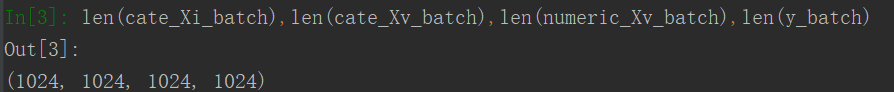

In [ ]:
def run_base_model_dcn(dfTrain, dfTest, folds, dcn_params):

    fd = FeatureDictionary(dfTrain,dfTest,numeric_cols=config.NUMERIC_COLS,
                           ignore_cols=config.IGNORE_COLS,
                           cate_cols = config.CATEGORICAL_COLS)

    print(fd.feat_dim)
    print(fd.feat_dict)

    data_parser = DataParser(feat_dict=fd)
    cate_Xi_train, cate_Xv_train, numeric_Xv_train,y_train = data_parser.parse(df=dfTrain, has_label=True)
    cate_Xi_test, cate_Xv_test, numeric_Xv_test,ids_test = data_parser.parse(df=dfTest)

    dcn_params["cate_feature_size"] = fd.feat_dim
    dcn_params["field_size"] = len(cate_Xi_train[0])
    dcn_params['numeric_feature_size'] = len(config.NUMERIC_COLS)

    _get = lambda x, l: [x[i] for i in l]

    for i, (train_idx, valid_idx) in enumerate(folds):
        cate_Xi_train_, cate_Xv_train_, numeric_Xv_train_,y_train_ = _get(cate_Xi_train, train_idx), _get(cate_Xv_train, train_idx),_get(numeric_Xv_train, train_idx), _get(y_train, train_idx)
        cate_Xi_valid_, cate_Xv_valid_, numeric_Xv_valid_,y_valid_ = _get(cate_Xi_train, valid_idx), _get(cate_Xv_train, valid_idx),_get(numeric_Xv_train, valid_idx), _get(y_train, valid_idx)

        dcn =  DCN(**dcn_params)

        dcn.fit(cate_Xi_train_, cate_Xv_train_, numeric_Xv_train_,y_train_, cate_Xi_valid_, cate_Xv_valid_, numeric_Xv_valid_,y_valid_)